# Upload files in Google Colab
If you are running this Jupyter Notebook on Google Colab, run this cell to upload the data files (train_inputs.csv, train_targets.csv, test_inputs.csv, test_targets.csv) in the colab virtual machine.  You will be prompted to select files that you would like to upload. 

If you are running this Jupyter Notebook on your computer, you do not need to run this cell.

In [ ]:
from google.colab import files
uploaded = files.upload()
%ls

# Import libraries 
Do not use any other Python library.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function: load_logistic_regression_data

This function loads the data for Logistic Regression from a local drive into RAM

Outputs:

*   **train_inputs**: numpy array of N training data points x M features
*   **train_labels**: numpy array of N training labels
*   **test_inputs**: numpy array of N' test data points x M features
*   **test_labels**: numpy array of N' test labels

In [ ]:
def load_logistic_regression_data():
    test_inputs = np.genfromtxt('test_inputs.csv', delimiter=',')
    test_labels = np.genfromtxt('test_labels.csv', delimiter=',')
    train_inputs = np.genfromtxt('train_inputs.csv', delimiter=',')
    train_labels = np.genfromtxt('train_labels.csv', delimiter=',')
    return train_inputs, train_labels, test_inputs, test_labels

# Function: sigmoid

This function implements the logistic sigmoid.

Input:
*   **input**: vector of inputs (numpy array of floats)

Output:
*   **output**: vector of outputs (numpy array of floats)

In [ ]:
def sigmoid(input):

    output = 1.0 / (1.0 + np.exp(-1.0 * input))
    return output

# Function: predict_logistic_regression

This function uses a vector of weights to make predictions for a set of inputs.  The prediction for each data point is a distribution over the labels.  Assume that there are only two possible labels {0,1}.

Inputs:
*   **inputs**: matrix of input data points for which we want to make a prediction (numpy array of N data points x M+1 features)
*   **weights**: vector of weights (numpy array of M+1 weights)

Output:
*   **predicted_probabilities**: matrix of predicted probabilities (numpy array of N data points x 2 labels)

In [ ]:
def predict_logistic_regression(inputs, weights):

    predicted_probabilities1 = sigmoid(np.matmul(weights, inputs.T)) # 1 * n
    predicted_probabilities2 = 1 - np.array(predicted_probabilities1)
    predicted_probabilities = np.array([predicted_probabilities1, predicted_probabilities2]).T
    return predicted_probabilities

# Function eval_logistic_regression

This function evaluates a set of predictions by computing the negative log probabilities of the labels and the accuracy (percentage of correctly predicted labels).  Assume that there are only two possible labels {0,1}.  A data point is correctly labeled when the probability of the target label is >= 0.5.

Inputs:
*   **inputs**: matrix of input data points for which we will evaluate the predictions (numpy array of N data points x M+1 features)
*   **weights**: vector of weights (numpy array of M+1 weights)
*   **labels**: vector of target labels associated with the inputs (numpy array of N labels)

Outputs:
*   **neg_log_prob**: negative log probability of the set of predictions (float)
*   **accuracy**: percentage of correctly labeled data points (float)

In [ ]:
def eval_logistic_regression(inputs, weights, labels):
  
    predicted = [0 for i in range(len(labels))]
    predicted_probabilities = predict_logistic_regression(inputs, weights)
    for i in range(len(predicted)):
        if (predicted_probabilities[i][0] >= 0.5):
            predicted[i] = 1
    count = 0
    for i in range(len(predicted)):
        if (predicted[i] == labels[i]):
            count += 1
    accuracy = float(count) / len(labels)
    
    generated = np.log(predicted_probabilities) # n * 2
    generated1 = np.matmul(generated[:,0],labels.T)
    generated2 = np.matmul(generated[:,1], (1 - np.array(labels)).T)
    neg_log_prob = -1 * (generated1 + generated2)
    return neg_log_prob, accuracy

Function: initialize_weights

This function initializes the weights uniformly at random in the interval [-0.05,0.05]

Input:
*   **n_weights**: # of weights to be initialized (integer)

Output:
*   **random_weights**: vector of weights (numpy array of floats)

In [ ]:
def initialize_weights(n_weights):

    random_weights = np.random.uniform(low=-0.05, high=0.05, size=n_weights)
    return random_weights

# Function train_logistic_regression

This function optimizes a set of weights for logistic regression based on a training set.  Initialize the weights with the function initialize_weights.  Implement Newton's algorithm to optimize the weights.  Stop Newton's algorithm when the maximum change for all weights is less than 0.001 in two consecutive iterations. Assume that there are only two labels {0,1}.

Inputs:
*   **train_inputs**: matrix of input training points (numpy array of N data points x M+1 features)
*   **train_labels**: vector of labels associated with the inputs (numpy array of N labels)
*   **lambda_hyperparam**: lambda hyperparameter used to adjust the importance of the regularizer (scalar)

Output:
*   **weights**: vector of weights that have been optimized (numpy array of M+1 weights)



In [ ]:
def train_logistic_regression(train_inputs, train_labels, lambda_hyperparam):

    n = train_inputs.shape[0]
    m = train_inputs.shape[1]
    weights = initialize_weights(m)
    while (True):
        predicted_probabilities = predict_logistic_regression(train_inputs, weights) # n * 2
        R = np.zeros(shape=(n, n))
        for i in range(n):
            R[i][i] = predicted_probabilities[i][0] * predicted_probabilities[i][1]
        H = np.matmul(np.matmul(train_inputs.T, R), train_inputs) + (lambda_hyperparam * np.identity(m))
        gradient = np.matmul(predicted_probabilities[:,0] - np.array(train_labels), train_inputs) + (lambda_hyperparam * np.array(weights))
        new_weights = weights - np.matmul(np.linalg.inv(H), gradient.T).T
        temp = np.max(np.absolute(new_weights - weights))
        if (temp < 0.001):
            weights = new_weights
            break
        weights = new_weights
        
    return weights

# Function cross_validation_logistic_regression

This function performs k-fold cross validation to determine the best lambda hyperparameter in logistic regression

Inputs:
*   **k_folds**: # of folds in cross-validation (integer)
*   **hyperparameters**: list of hyperparameters where each hyperparameter is a different lambda value (list of floats)
*   **inputs**: matrix of input points (numpy array of N data points by M+1 features)
*   **labels**: vector of labels associated with the inputs (numpy array of N labels)

Outputs:
*   **best_hyperparam**: best lambda value for logistic regression (float)
*   **best_neg_log_prob**: negative log probabilty achieved with best_hyperparam (float)
*   **neg_log_probabilities**: vector of negative log probabilities for the corresponding hyperparameters (numpy array of floats)



In [ ]:
def cross_validation_logistic_regression(k_folds, hyperparameters, inputs, labels):
    splited_input = np.array_split(inputs, k_folds)
    splited_labels = np.array_split(labels, k_folds)
    best_hyperparam = 0
    best_neg_log_prob = 0
    neg_log_probabilities = []
    offset = int(len(inputs) / k_folds)
    start = True
    for lambda_hyperparam in hyperparameters:
        temp = 0
        for i in range(k_folds):
            validation_x = splited_input[i]
            validation_y = splited_labels[i]
            train_x = np.concatenate(splited_input[:i] + splited_input[i+1:])
            train_y = np.concatenate(splited_labels[:i] + splited_labels[i+1:])
            weights = train_logistic_regression(train_x, train_y, lambda_hyperparam)
            neg_log_prob, accuracy = eval_logistic_regression(validation_x, weights, validation_y)
            temp += neg_log_prob
        avg_neg_prob = temp / float(k_folds)
        neg_log_probabilities.append(avg_neg_prob)
        if (start):
            best_neg_log_prob = avg_neg_prob
            best_hyperparam = lambda_hyperparam
            start = False
        if (avg_neg_prob < best_neg_log_prob):
            best_neg_log_prob = avg_neg_prob
            best_hyperparam = lambda_hyperparam
            
    return best_hyperparam, best_neg_log_prob, neg_log_probabilities

# Function: plot_logistic_regression_neg_log_probabilities

Function that plots the negative log probabilities for different lambda values (hyperparameters) in logistic regression based on cross validation

Inputs:
*   **neg_log_probabilities**: vector of negative log probabilities for the corresponding hyperparameters (numpy array of floats)
*   **hyperparams**: list of hyperparameters where each hyperparameter is a different lambda value (list of floats)

In [ ]:
def plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams):
    plt.plot(hyperparams,neg_log_probabilities)
    plt.ylabel('negative log probability')
    plt.xlabel('lambda')
    plt.show()

# Main Logistic Regression code

Load data (rescale the inputs to be in the [-1,1] range, add 1 at the end of each datapoint and rename the labels 5,6 to 0,1).
Use k-fold cross validation to find the best lambda value for logistic regression.
Plot the negative log probabilities for different lambda values.
Test logistic regression with the best lambda value.

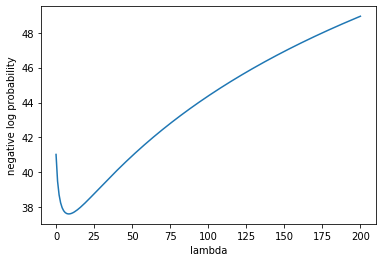

best lambda: 8
best cross validation negative log probability: 37.60806435493545
test accuracy: 0.8727272727272727
test negative log probability: 33.292030676420076


In [ ]:
# load data
train_inputs, train_labels, test_inputs, test_labels = load_logistic_regression_data()

# rescale inputs in the [-1,1] range
train_inputs = (train_inputs - 8)/8
test_inputs = (test_inputs - 8)/8

# add 1 at the end of each data point
train_inputs = np.concatenate((train_inputs,np.ones((train_inputs.shape[0],1))),1)
test_inputs = np.concatenate((test_inputs,np.ones((test_inputs.shape[0],1))),1)

# rename the classes 5,6 to 0,1
train_labels = train_labels.astype(int) - 5
test_labels = test_labels.astype(int) - 5

# lambda values to be evaluated by cross validation
hyperparams = range(201)
k_folds = 10
best_lambda, best_neg_log_prob, neg_log_probabilities = cross_validation_logistic_regression(k_folds,hyperparams,train_inputs,train_labels)

# plot results
plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams)
print('best lambda: ' + str (best_lambda))
print('best cross validation negative log probability: ' + str(best_neg_log_prob))

# train and evaluate with best lambda
weights = train_logistic_regression(train_inputs,train_labels,best_lambda)
neg_log_prob, accuracy = eval_logistic_regression(test_inputs, weights, test_labels)
print('test accuracy: ' + str(accuracy))
print('test negative log probability: ' + str(neg_log_prob))



Logistic Regression could provide a linear separator while knn could provide a non-linear separator. I would say non-linear separator could be more expressive since the decision boundary for non-linear seperator is more complex, which means that it could result in a larger hypothesis space. Thus non-linear separator could be more expressive. If the data set is linear separable, then linear separator will perform better. Otherwise, non-linear separator will preform better. Compared with A1, knn has lower accuracy that is because knn provide a non-linear separator so it is overfitting. When testing on the test sets, the accuracy could be lower.

test accuracy: 0.8727272727272727
test negative log probability: 33.292030647419566


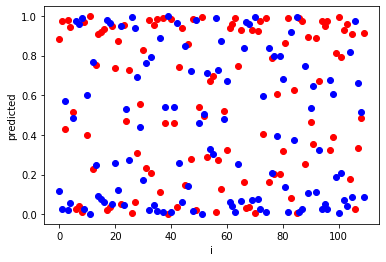

In [ ]:
# train and evaluate with best lambda
weights = train_logistic_regression(train_inputs,train_labels,best_lambda)
neg_log_prob, accuracy = eval_logistic_regression(test_inputs, weights, test_labels)
print('test accuracy: ' + str(accuracy))
print('test negative log probability: ' + str(neg_log_prob))

predict = predict_logistic_regression(test_inputs, weights)
plt.plot([i for i in range(len(test_inputs))],predict[:,0], 'ro')
plt.plot([i for i in range(len(test_inputs))],predict[:,1], 'bo')
plt.ylabel('predicted')
plt.xlabel('i')
plt.show()

The data set is not linear seperable. If the data is linear separable, the weight trained by the training data should also fit the test data set. So if the data is linear separable, the test accuracy should be relatively high. However, the current test accuracy is only 0.87 which is still relatively low. So the data is not linear separable.
According to the diagram above, the training set is not linear separable since there is no linear separator to separate two classes.